# Read VCTK data

In [3]:
! pip install tf_siren
! pip install --upgrade tf_siren
! pip install librosa
! pip install keras
! pip install tensorflow
! pip install --upgrade tensorflow

In [4]:
import os
import numpy as np
import librosa
import h5py
import random
from itertools import chain

from tf_siren import SinusodialRepresentationDense
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM, GRU
from keras.layers import Lambda, Conv1D, Lambda, Add, Conv1DTranspose
from keras.layers import LeakyReLU
import tensorflow as tf
from tensorflow.keras import layers, models

import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import os
import numpy as np
import wave
from scipy.fft import fft
import librosa
import IPython.display as ipd
from scipy.io import wavfile
import scipy.signal as signal

import math

In [4]:
# Download kaggle data in Google Colab
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d percywei/vctk-sr

100% 13.0G/13.1G [02:50<00:00, 115MB/s]
100% 13.1G/13.1G [02:50<00:00, 82.0MB/s]


In [ ]:
#unzip your dataset
!mkdir data
!mv vctk-sr.zip data
!unzip data/vctk-sr.zip -d data

串流輸出內容已截斷至最後 5000 行。
  inflating: data/train/train/48k/p272/p272_184.wav  
  inflating: data/train/train/48k/p272/p272_185.wav  
  inflating: data/train/train/48k/p272/p272_186.wav  
  inflating: data/train/train/48k/p272/p272_187.wav  
  inflating: data/train/train/48k/p272/p272_190.wav  
  inflating: data/train/train/48k/p272/p272_192.wav  
  inflating: data/train/train/48k/p272/p272_194.wav  
  inflating: data/train/train/48k/p272/p272_196.wav  
  inflating: data/train/train/48k/p272/p272_197.wav  
  inflating: data/train/train/48k/p272/p272_198.wav  
  inflating: data/train/train/48k/p272/p272_200.wav  
  inflating: data/train/train/48k/p272/p272_201.wav  
  inflating: data/train/train/48k/p272/p272_202.wav  
  inflating: data/train/train/48k/p272/p272_203.wav  
  inflating: data/train/train/48k/p272/p272_204.wav  
  inflating: data/train/train/48k/p272/p272_205.wav  
  inflating: data/train/train/48k/p272/p272_206.wav  
  inflating: data/train/train/48k/p272/p272_208.wav  
  infla

# Source from internet

In [5]:
# Load all of the file name of training data path name ex. /content/drive/MyDrive/data/train/train/48k/p255/p225_001.wav
def load_wav_list(dirname='data/'):
    file_list = []
    foldernames = os.listdir(dirname)
    #print(len(foldernames))
    file_extensions = set(['.wav'])
    for foldername in foldernames:
      if(foldername == ".DS_Store"):
          continue
      tmp_path = os.path.join(dirname, foldername)
      filenames = os.listdir(tmp_path)
      #print(len(filenames))
      for filename in filenames:
        ext = os.path.splitext(filename)[-1]
        if ext in file_extensions:
            full_filename = os.path.join(tmp_path, filename)
            file_list.append(full_filename)

    print('load wav list examples..')
    '''
    for i, file in enumerate(file_list):
        print(file)
        if i > 5: break
    '''
    return file_list

high_sr = 48000          # sampling rate
low_sr = 12000
dimension = 1024     # Input & Output size of model # Cut audio into len of dimension
stride = 256         # stride size
dimension2 = 1024     # Input & Output size of model # Cut audio into len of dimension
stride2 = 256
#file_list_X is an array of all high resolution training data path
my_wav_dir = '/Users/yenkuli/Desktop/final_project/data/train/train/48k'
file_list_X = load_wav_list(dirname=my_wav_dir)
#file_list_Y is an array of all low resolution training data path
my_wav_dir = '/Users/yenkuli/Desktop/final_project/data/train/train/16k'
file_list_Y = load_wav_list(dirname=my_wav_dir)
print(len(file_list_X))
print(len(file_list_Y))


load wav list examples..
load wav list examples..
24776
24776


In [6]:
# Load all of the file name of training data path name ex. /content/drive/MyDrive/data/train/train/48k/p255/p225_001.wav
def load_test_wav_list(dirname='data/'):
    file_list = []
    foldernames = os.listdir(dirname)
    #print(len(foldernames))
    file_extensions = set(['.wav'])
    for foldername in foldernames:
      if(foldername == ".DS_Store"):
          continue
      tmp_path = os.path.join(dirname, foldername)
      filenames = os.listdir(tmp_path)
      #print(len(filenames))
      for filename in filenames:
        ext = os.path.splitext(filename)[-1]
        if ext in file_extensions:
            full_filename = os.path.join(tmp_path, filename)
            file_list.append(full_filename)
    return file_list

#file_list_X is an array of all high resolution training data path
my_wav_dir = '/Users/yenkuli/Desktop/final_project/data/test/test/48k'
file_list_X_test = load_test_wav_list(dirname=my_wav_dir)
#file_list_Y is an array of all low resolution training data path
my_wav_dir = '/Users/yenkuli/Desktop/final_project/data/test/test/16k'
file_list_Y_test = load_test_wav_list(dirname=my_wav_dir)
print(len(file_list_X_test))
print(len(file_list_Y_test))


13272
13272


In [7]:
for i in range(len(file_list_X)):
  tmp1 = file_list_X[i] + "/"
  tmp2 = file_list_Y[i] + "/"
  tmp1 = os.path.dirname(tmp1).split("/")[-3:]
  tmp2 = os.path.dirname(tmp2).split("/")[-3:]
  #print(tmp1,tmp2)
  if(tmp1[1] != tmp2[1]):
    print("Error")
  if(tmp1[2] != tmp2[2]):
    print("Error")
  if(tmp1[0] != '48k'):
    print("Error")
  if(tmp2[0] != '16k'):
    print("Error")

In [78]:
from scipy import interpolate
def upsample(lr, r):
    n_lr = lr.flatten()
    hr_len = len(n_lr) * r
    sp = np.zeros(hr_len)

    i_lr = np.arange(hr_len, step=r)
    i_hr = np.arange(hr_len)

    f = interpolate.splrep(i_lr, n_lr)
    sp = interpolate.splev(i_hr, f)
    
    cutoff_frequency = 6000
    nor_cutoff = cutoff_frequency /(48000/2)
    filter_order = 100
    lowpass_filter = signal.firwin(filter_order, nor_cutoff)
    interpolateed_signal = signal.convolve(sp,lowpass_filter,mode='same')
    return sp

In [79]:
def read_audio(shuffle_index_list_train, shuffle_index_list_val):
  X_train = list()
  train_list_len = len(shuffle_index_list_train)
  for i in range(train_list_len):
    idx = shuffle_index_list_train[i]
    x_hr, fs = librosa.load(file_list_X[idx], sr=48000)
    x_hr = np.reshape(x_hr,(len(x_hr),1))
    #print(x_hr.shape)
    for j in range(0, x_hr.shape[0]-dimension , stride):
      hr_patch = x_hr[j:j+dimension]
      X_train.append(hr_patch)
  X_len = len(X_train)
  X_train = np.array(X_train[0:X_len])

  X_val = list()
  val_list_len = len(shuffle_index_list_val)
  for i in range(val_list_len):
    idx = shuffle_index_list_val[i]
    x_hr, fs = librosa.load(file_list_X[idx], sr=48000)
    x_hr = np.reshape(x_hr,(len(x_hr),1))
    for j in range(0, x_hr.shape[0]-dimension , stride):
      hr_patch = x_hr[j:j+dimension]
      X_val.append(hr_patch)
  X_len = len(X_val)
  X_val = np.array(X_val[0:X_len])

  Y_train = list()
  train_list_len = len(shuffle_index_list_train)
  for i in range(train_list_len):
    idx = shuffle_index_list_train[i]
    y_lr, fs = librosa.load(file_list_Y[idx], sr=12000)
    y_hr = upsample(y_lr, 4)
    #y_hr =y_lr
    y_hr = np.reshape(y_hr,(len(y_hr),1))
    for j in range(0, y_hr.shape[0]-dimension2 , stride2):
      hr_patch = y_hr[j:j+dimension2]
      #hr_patch1 = np.convolve(hr_patch.flatten(),my_filter)
      
      hr_patch = np.reshape(hr_patch,(len(hr_patch),1))
      Y_train.append(hr_patch)
  Y_len = len(Y_train)
  Y_train = np.array(Y_train[0:Y_len])
  


  Y_val = list()
  val_list_len = len(shuffle_index_list_val)
  for i in range(val_list_len):
    idx = shuffle_index_list_val[i]
    y_lr, fs = librosa.load(file_list_Y[idx], sr=12000)
    y_hr = upsample(y_lr, 4)
    #y_hr =y_lr
    y_hr = np.reshape(y_hr,(len(y_hr),1))
    for j in range(0, y_hr.shape[0]-dimension2 , stride2):
      hr_patch = y_hr[j:j+dimension2]
      #hr_patch1 = np.convolve(hr_patch.flatten(),my_filter)
      hr_patch = np.reshape(hr_patch,(len(hr_patch),1))
      Y_val.append(hr_patch)
  Y_len = len(Y_val)
  Y_val = np.array(Y_val[0:Y_len])
  


  return X_train,Y_train,X_val,Y_val

In [80]:
def plot_specturm(signal , title , fs, filter_or_signal=0):

    np.set_printoptions(suppress=True)
    plt.figure()

    fft_signal = np.fft.fft(signal)
    magnitude_specturm = np.abs(fft_signal)/np.max(fft_signal)
    frequency = np.fft.fftfreq(len(signal) , 1/fs)

    result = np.stack((frequency, magnitude_specturm), axis=-1)
    result  = result[result[:, 0].argsort()]

    #plt.clf()
    plt.xlabel('frequency')
    plt.ylabel('magnitude')
    plt.plot(result[:,0] , result[:,1])
    plt.xlim(-20000,20000)
    plt.title(title)
    #plt.savefig('example_plot.png')

In [81]:
def PSNR(y_true,y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    max_value = tf.reduce_max(y_true)
    psnr = 10 * tf.math.log( (max_value**2) / mse ) / tf.math.log(10.0)
    return psnr



In [83]:
def predict_single_wav(h_sr_path, l_sr_path, input_model):
  y_pred, fs = librosa.load(l_sr_path, sr=12000)
  #print(y_pred.shape)
  y_pred = upsample(y_pred, 4)
  #print(y_pred.shape)
  y_pred_patches = list()
  for i in range(0,y_pred.shape[0]-dimension2, dimension2):
    y_pred_patch = y_pred[i:i+dimension2]
    #y_pred_patch = np.convolve(y_pred_patch,my_filter)
    y_pred_patch = np.reshape(y_pred_patch, (y_pred_patch.shape[0],1))
    y_pred_patches.append(y_pred_patch)
  y_pred_patches = np.array(y_pred_patches[0:len(y_pred_patches)])
  #print(y_pred_patches.shape)
  pred = input_model(y_pred_patches)
  pred_arr = np.array(pred)
  #print(pred_arr.shape)
  pred_arr = np.reshape(pred_arr, (-1, 1))
  #print(pred_arr.shape)

  wavfile.write("/Users/yenkuli/Desktop/final_project/1.wav", 48000, pred_arr.astype(np.float32))

  # test and visualize the audio
  wave48=h_sr_path
  wave16=l_sr_path
  wave_pred = "/Users/yenkuli/Desktop/final_project/1.wav"
  rate48, data48 = wavfile.read(wave48)
  rate16, data16 = wavfile.read(wave16)
  rate_pred, data_pred = wavfile.read(wave_pred)
  #print(rate48,rate16, rate_pred)
  #print(len(data48),len(data16), len(data_pred))
  #plot_specturm(data48 , '48K' , rate48, filter_or_signal=0)
  #plot_specturm(data16 ,'16K' , rate16, filter_or_signal=0)
  plot_specturm(data_pred ,'48K' , rate_pred, filter_or_signal=0)
  
  #data16_up = upsample(data16,4)
  data16, fs = librosa.load(l_sr_path, sr=12000)
  data48, fs = librosa.load(h_sr_path, sr=48000)
  data16_up = upsample(data16,4)
  #print(data16_up)
  #print(data48)
  #print(data_pred)

  mse = np.mean((data48- data16_up[0:data48.shape[0]]) ** 2)
  max_value = np.max(data48)
  psnr = 10 * np.log10((max_value **2) / mse)
  print(psnr)

  mse = np.mean((data48[0:data_pred.shape[0]]- data_pred) ** 2)
  max_value = np.max(data48)
  psnr = 10 * np.log10((max_value **2) / mse)
  print(psnr)
  '''
  mse = np.mean((data48 - data48) ** 2 + 0.00000001)
  max_value = np.max(data48)
  psnr = 10 * np.log10((max_value **2) / mse)
  print(psnr)
  '''
  audio_48 = ipd.Audio(wave48)
  audio_16 = ipd.Audio(wave16)
  audio_pred = ipd.Audio(wave_pred)

  #ipd.display(audio_48)
  #ipd.display(audio_16)
  ipd.display(audio_pred)

In [84]:
class RFFTLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(RFFTLayer, self).__init__()

    def call(self, inputs):
        # Apply FFT operation to the input data
        fft_output = tf.signal.fft(tf.cast(inputs, tf.complex64))
        fft_output = tf.math.real(fft_output)
        return fft_output

In [74]:
class IFFTLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(IFFTLayer, self).__init__()

    def call(self, inputs):
        # Apply FFT operation to the input data
        fft_output = tf.signal.fft(tf.cast(inputs, tf.complex64))
        fft_output = tf.math.imag(fft_output)
        return fft_output

In [75]:
class InverseFFTLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(InverseFFTLayer, self).__init__()

    def call(self, inputs1,inputs2):
        # Apply FFT operation to the input data
        fft_output = tf.complex(inputs1, inputs2)
        fft_output = tf.signal.ifft(fft_output)
        fft_output = tf.math.real(fft_output)
        return fft_output

In [92]:
def base_model(summary=True):
    print('load base model..')
    x = keras.layers.Input((dimension2,1))
    main_input = x
    
    real_input = RFFTLayer() (x)
    imag_input = IFFTLayer() (x)
    
    real_x = real_input
    imag_x = imag_input
    
    activation_func = 'elu'
    kernel_initializer = 'he_normal'
    dropout_rate = 0.3
    
    # Donwsampling layer 1
    real_x = Conv1D(kernel_initializer=kernel_initializer, filters=4, kernel_size=16, activation=None, strides=2)(real_x)
    real_x = Activation(activation_func)(real_x)
    real_x = SinusodialRepresentationDense(8,activation='sine',w0=1.0)(real_x)
    real_x1 = real_x

    # Donwsampling layer 2
    real_x = Conv1D(kernel_initializer=kernel_initializer, filters=8, kernel_size=8, activation=None, strides=2)(real_x)
    real_x = Activation(activation_func)(real_x)
    #x = SinusodialRepresentationDense(16,activation='sine',w0=1.0)(x)
    real_x2 = real_x

    # Donwsampling layer 3
    real_x = Conv1D(kernel_initializer=kernel_initializer, filters=8, kernel_size=4, activation=None, strides=2)(real_x)
    real_x = Activation(activation_func)(real_x)
    #x = SinusodialRepresentationDense(16,activation='sine',w0=1.0)(x)
    real_x3 = real_x # 32

    # Donwsampling layer 4
    real_x = Conv1D(kernel_initializer=kernel_initializer, filters=16, kernel_size=4, activation=None, strides=2)(real_x)
    real_x = Activation(activation_func)(real_x)
    #x = SinusodialRepresentationDense(16,activation='sine',w0=1.0)(x)
    real_x4 = real_x # 16

    # Donwsampling layer 5
    real_x = Conv1D(kernel_initializer=kernel_initializer, filters=16, kernel_size=4, activation=None, strides=2)(real_x)
    real_x = Activation(activation_func)(real_x)
    #x = SinusodialRepresentationDense(32,activation='sine',w0=1.0)(x)
    real_x5 = real_x # 8

    # Donwsampling layer 6
    real_x = Conv1D(kernel_initializer=kernel_initializer, filters=32, kernel_size=4, activation=None, strides=2)(real_x)
    real_x = Activation(activation_func)(real_x)
    #x = SinusodialRepresentationDense(32,activation='sine',w0=1.0)(x)
    real_x6 = real_x # 4

    # Bottleneck layer
    real_x = layers.Conv1D(kernel_initializer=kernel_initializer, filters=32, kernel_size=4, activation=None, strides=2,name='bottleneck')(real_x)
    real_x = Activation(activation_func)(real_x)
    x = SinusodialRepresentationDense(32,activation='sine',w0=1.0)(x)

    # Upsampling layer 6
    real_x = Conv1DTranspose(kernel_initializer=kernel_initializer,filters=32, kernel_size=5, activation=None, strides=2)(real_x)
    real_x = Activation(activation_func)(real_x)
    #x = SinusodialRepresentationDense(32,activation='sine',w0=1.0)(x)
    real_x = Dropout(rate=dropout_rate)(real_x)
    real_x = Add()([real_x, real_x6])

    # Upsampling layer 5
    real_x = layers.Conv1DTranspose(kernel_initializer=kernel_initializer,filters=16, kernel_size=5, activation=None, strides=2)(real_x)
    real_x = Activation(activation_func)(real_x)
    #x = SinusodialRepresentationDense(32,activation='sine',w0=1.0)(x)
    real_x = Dropout(rate=dropout_rate)(real_x)
    real_x = Add()([real_x, real_x5])

    # Upsampling layer 4
    real_x = layers.Conv1DTranspose(kernel_initializer=kernel_initializer,filters=16, kernel_size=4, activation=None, strides=2)(real_x)
    real_x = Activation(activation_func)(real_x)
    #x = SinusodialRepresentationDense(16,activation='sine',w0=1.0)(x)
    real_x = Dropout(rate=dropout_rate)(real_x)
    real_x = Add()([real_x, real_x4])


    # Upsampling layer 3
    real_x = layers.Conv1DTranspose(kernel_initializer=kernel_initializer,filters=8, kernel_size=5, activation=None, strides=2)(real_x)
    real_x = Activation(activation_func)(real_x)
    #x = SinusodialRepresentationDense(16,activation='sine',w0=1.0)(x)
    real_x = Dropout(rate=dropout_rate)(real_x)
    real_x = Add()([real_x, real_x3])


    # Upsampling layer 2
    real_x = layers.Conv1DTranspose(kernel_initializer=kernel_initializer,filters=8, kernel_size=5, activation=None, strides=2)(real_x)
    real_x = Activation(activation_func)(real_x)
    #x = SinusodialRepresentationDense(16,activation='sine',w0=1.0)(x)
    real_x = Dropout(rate=dropout_rate)(real_x)
    real_x = Add()([real_x, real_x2])

    # Upsampling layer 1
    real_x = layers.Conv1DTranspose(kernel_initializer=kernel_initializer,filters=4, kernel_size=9, activation=None, strides=2)(real_x)
    real_x = Activation(activation_func)(real_x)
    real_x = SinusodialRepresentationDense(8,activation='sine',w0=1.0)(real_x)
    real_x = Dropout(rate=dropout_rate)(real_x)
    real_x = Add()([real_x, real_x1])



    imag_x = Conv1D(kernel_initializer=kernel_initializer, filters=4, kernel_size=16, activation=None, strides=2)(imag_x)
    imag_x = Activation(activation_func)(imag_x)
    imag_x = SinusodialRepresentationDense(8,activation='sine',w0=1.0)(imag_x)
    imag_x1 = imag_x # 128

    # Donwsampling layer 2
    imag_x = Conv1D(kernel_initializer=kernel_initializer, filters=8, kernel_size=8, activation=None, strides=2)(imag_x)
    imag_x = Activation(activation_func)(imag_x)
    #imag_x = SinusodialRepresentationDense(16,activation='sine',w0=1.0)(imag_x)
    imag_x2 = imag_x # 64

    # Donwsampling layer 3
    imag_x = Conv1D(kernel_initializer=kernel_initializer, filters=8, kernel_size=4, activation=None, strides=2)(imag_x)
    imag_x = Activation(activation_func)(imag_x)
    #imag_x = SinusodialRepresentationDense(16,activation='sine',w0=1.0)(imag_x)
    imag_x3 = imag_x # 32

    # Donwsampling layer 4
    imag_x = Conv1D(kernel_initializer=kernel_initializer, filters=16, kernel_size=4, activation=None, strides=2)(imag_x)
    imag_x = Activation(activation_func)(imag_x)
    #imag_x = SinusodialRepresentationDense(16,activation='sine',w0=1.0)(imag_x)
    imag_x4 = imag_x # 16

    # Donwsampling layer 5
    imag_x = Conv1D(kernel_initializer=kernel_initializer, filters=16, kernel_size=4, activation=None, strides=2)(imag_x)
    imag_x = Activation(activation_func)(imag_x)
    #imag_x = SinusodialRepresentationDense(32,activation='sine',w0=1.0)(imag_x)
    imag_x5 = imag_x # 8

    # Donwsampling layer 6
    imag_x = Conv1D(kernel_initializer=kernel_initializer, filters=32, kernel_size=4, activation=None, strides=2)(imag_x)
    imag_x = Activation(activation_func)(imag_x)
    #imag_x = SinusodialRepresentationDense(32,activation='sine',w0=1.0)(imag_x)
    imag_x6 = imag_x # 4

    # Bottleneck layer
    imag_x = Conv1D(kernel_initializer=kernel_initializer, filters=32, kernel_size=4, activation=None, strides=2,name='bottleneck_freq')(imag_x)
    imag_x = Activation(activation_func)(imag_x)
    #imag_x = SinusodialRepresentationDense(32,activation='sine',w0=1.0)(imag_x)

    # Upsampling layer 6
    imag_x = Conv1DTranspose(kernel_initializer=kernel_initializer,filters=32, kernel_size=5, activation=None, strides=2)(imag_x)
    imag_x = Activation(activation_func)(imag_x)
    #imag_x = SinusodialRepresentationDense(32,activation='sine',w0=1.0)(imag_x)
    imag_x = Dropout(rate=dropout_rate)(imag_x)
    imag_x = Add()([imag_x, imag_x6])

    # Upsampling layer 5
    imag_x = Conv1DTranspose(kernel_initializer=kernel_initializer,filters=16, kernel_size=5, activation=None, strides=2)(imag_x)
    imag_x = Activation(activation_func)(imag_x)
    #imag_x = SinusodialRepresentationDense(32,activation='sine',w0=1.0)(imag_x)
    imag_x = Dropout(rate=dropout_rate)(imag_x)
    imag_x = Add()([imag_x, imag_x5])

    # Upsampling layer 4
    imag_x = Conv1DTranspose(kernel_initializer=kernel_initializer,filters=16, kernel_size=4, activation=None, strides=2)(imag_x)
    imag_x = Activation(activation_func)(imag_x)
    #imag_x = SinusodialRepresentationDense(16,activation='sine',w0=1.0)(imag_x)
    imag_x = Dropout(rate=dropout_rate)(imag_x)
    imag_x = Add()([imag_x, imag_x4])


    # Upsampling layer 3
    imag_x = Conv1DTranspose(kernel_initializer=kernel_initializer,filters=8, kernel_size=5, activation=None, strides=2)(imag_x)
    imag_x = Activation(activation_func)(imag_x)
    #imag_x = SinusodialRepresentationDense(16,activation='sine',w0=1.0)(imag_x)
    imag_x = Dropout(rate=dropout_rate)(imag_x)
    imag_x = Add()([imag_x, imag_x3])


    # Upsampling layer 2
    imag_x = Conv1DTranspose(kernel_initializer=kernel_initializer,filters=8, kernel_size=5, activation=None, strides=2)(imag_x)
    imag_x = Activation(activation_func)(imag_x)
    #imag_x = SinusodialRepresentationDense(16,activation='sine',w0=1.0)(imag_x)
    imag_x = Dropout(rate=dropout_rate)(imag_x)
    imag_x = Add()([imag_x, imag_x2])

    # Upsampling layer 1
    imag_x = Conv1DTranspose(kernel_initializer=kernel_initializer,filters=8, kernel_size=9, activation=None, strides=2)(imag_x)
    imag_x = Activation(activation_func)(imag_x)
    imag_x = SinusodialRepresentationDense(8,activation='sine',w0=1.0)(imag_x)
    imag_x = Dropout(rate=dropout_rate)(imag_x)
    imag_x = Add()([imag_x, imag_x1])




    imag_x = layers.Conv1DTranspose(kernel_initializer=kernel_initializer,filters=1, kernel_size=16, activation=None, strides=2)(imag_x)
    output_imag = Add()([imag_x, imag_input])

    real_x = layers.Conv1DTranspose(kernel_initializer=kernel_initializer,filters=1, kernel_size=16, activation=None, strides=2)(real_x)
    output_real = Add()([real_x, real_input])
    
    output = InverseFFTLayer()(output_real, output_imag)
    
    #output = Conv1D(kernel_initializer=kernel_initializer,filters=1, kernel_size=1, activation=None, strides=1) (output)
    #output = Add()([output_time, output_freq])
    model  = keras.models.Model(main_input,output)


    model.summary()

    return model
#ref_model = base_model()

In [93]:
my_model = base_model()
optimizer = keras.optimizers.Adam(learning_rate=0.001)
my_model.compile(loss='mse', optimizer=optimizer, metrics=[PSNR])

load base model..
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1024, 1)]    0           []                               
                                                                                                  
 rfft_layer_5 (RFFTLayer)       (None, 1024, 1)      0           ['input_6[0][0]']                
                                                                                                  
 ifft_layer_5 (IFFTLayer)       (None, 1024, 1)      0           ['input_6[0][0]']                
                                                                                                  
 conv1d_60 (Conv1D)             (None, 505, 4)       68          ['rfft_layer_5[0][0]']           
                                                                          

In [95]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
my_model.compile(loss='mse', optimizer=optimizer, metrics=[PSNR])

In [40]:
save_model=my_model

[18647, 21737, 18820, 20350, 12238, 833, 2365, 28, 24228, 17683, 12132, 17941, 17059, 4718, 21229, 6129, 7904, 8847, 24589, 2931, 4389, 16169, 11346, 1646, 9633, 18774, 18753, 10504, 7148, 19034, 3071, 21062, 11687, 4354, 21113, 12598, 20794, 14011, 7050, 23765, 8450, 10327, 1287, 24101, 10601, 5117, 16438, 23734, 3182, 562, 16619, 14675, 13098, 15027, 17792, 9493, 10779, 14434, 895, 21360, 21991, 5953, 11105, 15336, 20624, 14249, 14579, 8223, 15057, 15182, 20957, 14255, 287, 21940, 2103, 8133, 14481, 16034, 11805, 16019, 7467, 10176, 14795, 15425, 10615, 17717, 15393, 23006, 17359, 5383, 8200, 5455, 3097, 15987, 23572, 23124, 21291, 19497, 5484, 17038, 22764, 16648, 5413, 5079, 8959, 20354, 4407, 8349, 2698, 20871, 5858, 23305, 21364, 8770, 19974, 10518, 4927, 5754, 14884, 18293, 788, 10619, 23728, 18038, 13592, 3670, 18071, 2077, 20400, 4918, 10616, 23294, 24529, 5041, 15432, 10426, 14331, 16743, 13177, 11403, 18534, 16448, 14916, 11798, 2985, 8037, 5051, 7530, 10231, 21643, 622, 198

100
(50504, 1024, 1)
198/198 [==============================] - 50s 254ms/step - loss: 3.5014e-05 - PSNR: 38.4604 - val_loss: 4.6924e-05 - val_PSNR: 37.8804
200
(49404, 1024, 1)
193/193 [==============================] - 50s 261ms/step - loss: 3.9675e-05 - PSNR: 37.8385 - val_loss: 3.6833e-05 - val_PSNR: 39.1951
300
(54048, 1024, 1)
212/212 [==============================] - 55s 261ms/step - loss: 4.8094e-05 - PSNR: 37.5838 - val_loss: 3.7027e-05 - val_PSNR: 38.7152
400
(52216, 1024, 1)
204/204 [==============================] - 53s 261ms/step - loss: 4.1388e-05 - PSNR: 37.9133 - val_loss: 3.2736e-05 - val_PSNR: 38.2514
500
(52992, 1024, 1)
207/207 [==============================] - 52s 250ms/step - loss: 3.0491e-05 - PSNR: 39.0138 - val_loss: 3.7973e-05 - val_PSNR: 39.1940
600
(50828, 1024, 1)
199/199 [==============================] - 54s 270ms/step - loss: 3.9177e-05 - PSNR: 37.8749 - val_loss: 2.6776e-05 - val_PSNR: 39.0868
700
(52968, 1024, 1)
207/207 [============================

1100
(53696, 1024, 1)
210/210 [==============================] - 53s 255ms/step - loss: 4.1791e-05 - PSNR: 38.3480 - val_loss: 2.2638e-05 - val_PSNR: 40.5049
1200
(55625, 1024, 1)
218/218 [==============================] - 57s 261ms/step - loss: 2.7091e-05 - PSNR: 38.8974 - val_loss: 5.2957e-05 - val_PSNR: 37.6043
1300
(54824, 1024, 1)
215/215 [==============================] - 54s 249ms/step - loss: 3.6503e-05 - PSNR: 38.0728 - val_loss: 2.2612e-05 - val_PSNR: 39.6702
1400
(50144, 1024, 1)
196/196 [==============================] - 50s 255ms/step - loss: 3.9654e-05 - PSNR: 39.4046 - val_loss: 4.2289e-05 - val_PSNR: 39.9094
1500
(51400, 1024, 1)
201/201 [==============================] - 51s 256ms/step - loss: 3.0303e-05 - PSNR: 39.3710 - val_loss: 6.0340e-05 - val_PSNR: 39.3867
1600
(51944, 1024, 1)
203/203 [==============================] - 50s 245ms/step - loss: 2.9895e-05 - PSNR: 39.4985 - val_loss: 3.2165e-05 - val_PSNR: 39.7761
1700
(52410, 1024, 1)
144/205 [====================>

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

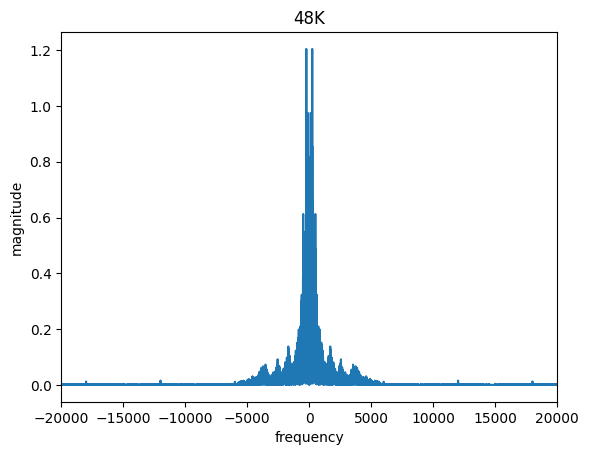

In [96]:
EPOCHS = 15
#OUTER_BATCH_SIZE = 120
OUTER_TRAIN_BATCH_SIZE = 80
OUTER_VAL_BATCH_SIZE = 20
OUTER_BATCH_SIZE = OUTER_TRAIN_BATCH_SIZE + OUTER_VAL_BATCH_SIZE
INNER_BATCH_SIZE = 256
SHUFFLE = False
history = list()
for i in range(EPOCHS):
  random_idx_list = random.sample(range(len(file_list_X)), len(file_list_X))
  print(random_idx_list)
  for j in range(0,len(file_list_X)-OUTER_BATCH_SIZE,OUTER_BATCH_SIZE):
    print(j)
    X_train,Y_train,X_val,Y_val = read_audio(random_idx_list[j:j+OUTER_TRAIN_BATCH_SIZE],random_idx_list[j+OUTER_TRAIN_BATCH_SIZE:j+OUTER_BATCH_SIZE])
    
    print(Y_train.shape)
    tmp = my_model.fit(Y_train, X_train, batch_size=INNER_BATCH_SIZE,epochs=1,shuffle=SHUFFLE, validation_data=(Y_val, X_val))
    history.append(tmp)
    if(j%1000 == 0):
      plt.clf()
      predict_single_wav(file_list_X[20004],file_list_Y[20004],my_model)
      plt.savefig('/Users/yenkuli/Desktop/final_project/'+str(j) + '.png')
    #if(j%1000 == 0 and j != 0):
      #my_model.save("/Users/yenkuli/Desktop/final_project/my_model.h5")


In [ ]:
#new_model = models.load_model("my_model.h5", custom_objects={"PSNR":PSNR})

In [97]:
def predict_single_wav_shown_all(input_model, idx):
  h_sr_path = file_list_X[idx]
  l_sr_path = file_list_Y[idx]

  y_pred, fs = librosa.load(l_sr_path, sr=12000)
  print(y_pred.shape)
  y_pred = upsample(y_pred, 4)
  print(y_pred.shape)
  y_pred_patches = list()
  for i in range(0,y_pred.shape[0]-dimension2, dimension2):
    y_pred_patch = y_pred[i:i+dimension2]
    y_pred_patch = np.reshape(y_pred_patch, (y_pred_patch.shape[0],1))
    y_pred_patches.append(y_pred_patch)
  y_pred_patches = np.array(y_pred_patches[0:len(y_pred_patches)])
  print(y_pred_patches.shape)
  pred = input_model(y_pred_patches)
  pred_arr = np.array(pred)
  print(pred_arr.shape)
  pred_arr = np.reshape(pred_arr, (-1, 1))
  print(pred_arr.shape)

  wavfile.write("/Users/yenkuli/Desktop/final_project/1.wav", 48000, pred_arr.astype(np.float32))

  # test and visualize the audio
  wave48=h_sr_path
  wave16=l_sr_path
  wave_pred = "/Users/yenkuli/Desktop/final_project/1.wav"
  rate48, data48 = wavfile.read(wave48)
  rate16, data16 = wavfile.read(wave16)
  rate_pred, data_pred = wavfile.read(wave_pred)
  print(rate48,rate16, rate_pred)
  print(len(data48),len(data16), len(data_pred))
  plot_specturm(data48 , '48K' , rate48, filter_or_signal=0)
  plot_specturm(data16 ,'16K' , rate16, filter_or_signal=0)
  plot_specturm(data_pred ,'48K_pred' , rate_pred, filter_or_signal=0)
  
  #data16_up = upsample(data16,4)
  
  data16, fs = librosa.load(l_sr_path, sr=12000)
  data48, fs = librosa.load(h_sr_path, sr=48000)
  data16_up = upsample(data16,4)
  print(data16_up)
  print(data48)
  print(data_pred)
  plot_specturm(data16_up ,'16K_up' , rate48, filter_or_signal=0)

  mse = np.mean((data48- data16_up[0:data48.shape[0]]) ** 2)
  max_value = np.max(data48)
  psnr = 10 * np.log10((max_value **2) / mse)
  print(psnr)

  mse = np.mean((data48[0:data_pred.shape[0]]- data_pred) ** 2)
  max_value = np.max(data48)
  psnr = 10 * np.log10((max_value **2) / mse)
  print(psnr)
  

  audio_48 = ipd.Audio(wave48)
  audio_16 = ipd.Audio(wave16)
  audio_pred = ipd.Audio(wave_pred)

  ipd.display(audio_48)
  ipd.display(audio_16)
  ipd.display(audio_pred)

In [108]:
predict_single_wav_shown_all(save_model,22000)

NameError: name 'save_model' is not defined

In [101]:
def calculaate_psnr(input_model):
    psnr_list = list()
    log_dis_list = list()
    for i in range(len(file_list_X_test)):
        if(i%100==0):
            print(i)

        y_pred, fs = librosa.load(file_list_Y_test[i], sr=12000)
        #print(y_pred.shape)
        y_pred = upsample(y_pred, 4)
        #print(y_pred.shape)
        y_pred_patches = list()
        for j in range(0,y_pred.shape[0]-dimension2, dimension2):
            y_pred_patch = y_pred[j:j+dimension2]
            y_pred_patch = np.reshape(y_pred_patch, (y_pred_patch.shape[0],1))
            y_pred_patches.append(y_pred_patch)
        y_pred_patches = np.array(y_pred_patches[0:len(y_pred_patches)])
        #print(y_pred_patches.shape)
        pred = input_model(y_pred_patches)
        pred_arr = np.array(pred)
        #print(pred_arr.shape)
        pred_arr = np.reshape(pred_arr, (-1, 1))
        #print(pred_arr.shape)
        #print(pred_arr)

        wavfile.write("/Users/yenkuli/Desktop/final_project/1.wav", 48000, pred_arr.astype(np.float32))
        #data_pred = pred_arr.astype(np.float32)
        data48, fs = librosa.load(file_list_X_test[i], sr=48000)
        data_pred, fs = librosa.load("/Users/yenkuli/Desktop/final_project/1.wav",sr=48000)
        #print(data48)
        #print(data_pred)
        #data_pred = pred_arr

        mse = np.mean((data48[0:data_pred.shape[0]]- data_pred) ** 2)
        max_value = np.max(data48)
        psnr = 10 * np.log10((max_value **2) / mse)
        psnr_list.append(psnr)
        #print(psnr)
        
        data48 = data48[0:data_pred.shape[0]]
        stft1 = librosa.stft(data48)
        stft2 = librosa.stft(data_pred)
        log1 = librosa.amplitude_to_db(np.abs(stft1))
        log2 = librosa.amplitude_to_db(np.abs(stft2))
        log_dis = np.mean(log1-log2)
        log_dis_list.append(log_dis)
    return psnr_list
        

In [102]:
psnr_list = calculaate_psnr(my_model)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200


In [103]:
print(psnr_list)

[50.56515712053982, 51.72753612660516, 46.26578572556003, 48.04758110479006, 49.015948160151794, 46.39220314339824, 50.18700723380299, 54.039418594471385, 46.23910001913261, 44.171299378062294, 40.05755788202577, 45.284578137047085, 47.58883340986975, 43.53854683778438, 53.64959530716192, 43.50442527682233, 54.249291670114204, 40.000815737759126, 45.118041523443786, 49.366091941865264, 50.2000336767923, 42.943919096765995, 44.61316391359945, 48.501877458577894, 51.718315878833366, 49.52332862015116, 54.467065605833724, 50.114599892000165, 42.8438123329584, 49.5778257794439, 49.358454528079506, 44.86911232154202, 47.372670978919736, 48.82550248891206, 40.04924948061561, 50.0733357816426, 45.523557793785905, 51.343291989491284, 47.78937491215204, 53.007862093644896, 46.92832584055124, 46.53224266606645, 51.05900573107225, 45.682236121987316, 49.66255509719736, 47.088024030882835, 44.75669202165604, 45.5043333356104, 52.798093629147935, 47.68143729873061, 50.21475718781972, 42.14261631269

In [105]:
tmp = psnr_list
tmp = np.array(tmp)
tmp = np.mean(tmp)
print(tmp)

40.440196003017434
